# Data models and analyses techniques: Exercise sheet 1

#### *Your name:* Kenneth Elong

## Introduction

For each lecture there will be a collection of exercises presented as Jupyter notebooks. The exercises should be solved and documented as a mini-project that will form the basis for the examination. When solving the exercises it is therefore important that you 
 * document all relevant results and analyses that you have obtained/performed during the exercises.
 * try to relate your results to the theoretical background of the methods being applied. 

The documentation should be integrated (by adding new code/markdown cells) in the Jupyter notebooks containing the exercise sheets.

The mini-project should be delivered after the last seminar in this module (an exact date will be provided later) and should consist of:
 - a single pdf-file containing all the notebooks; the 'File' menu gives you the option of downloading a pdf-version of your notebook. The name of the file should be [your\_first\_name]_[your\_family\_name].pdf (e.g. Thomas\_Nielsen.pdf).
 - a copy of your notebooks with the solutions to the exercises. The notebooks should be named [your\_first name]\_[your\_family\_name]\_[exercise\_sheet\_number].ipynb (e.g., Thomas\_Nielsen\_1.ipnyb).
 
If you have any questions about the exercises, you are strongly encouraged to post you questions on the MS Teams channel or on the discussion forum on Moodle.

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Introduction to answering the exercises** - Comments by Kenneth Elong

The following code and answers have been done by Kenneth Elong. I have not collaborated with other group members, though there have been back and forth discussion about some exercises.

In many cases I have opted to set a random state. While having random state does not reflect real life scenarios it is done to make sure that the results I have commented on can be recreated. My learning and my ability to express that learning is the focal point, making reproducibility more important than imitating real life.

I have in some cases made some fairly elaborate code constructions. The purpose has been to automate iterating through different scenarios. 

I've strived, for each code section, to start with the exercise text provided in the beginning, so it is clear which questions I'm looking to answer with the code. Also for the more elaborate code constructions I've provided explanations before or as comments in the code. I have focused on code readability so that the readers quickly should be able to understand what the codes does.

# Data source

In this exercise we will play around with the a subset of the Boston housing data set, which is available at `http://lib.stat.cmu.edu/datasets/boston`. The data is unfortunately not available through sklearn, so instead we will have to download and massage it a bit.

In [1]:
#%pip install requests 

import pandas as pd
import requests
from io import StringIO
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

url = 'http://lib.stat.cmu.edu/datasets/boston'
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the content of the response as a string and split into lines
    lines = response.text.splitlines()
    meta = "\n".join(lines[0:21])
    
    # Drop lines with meta data
    lines = lines[22:]
    
    # Column names
    col_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

    # Join every two lines (rows are broken over two lines)
    combined_lines = []
    for i in range(0, len(lines), 2):
        combined_line = lines[i].strip() + " " + lines[i + 1].strip()
        combined_lines.append(combined_line)

    # Combine all lines into a single string
    s = "\n".join(combined_lines)
    
    # Read into a DataFrame using StringIO
    df = pd.read_csv(StringIO(s), delim_whitespace=True, header=None, names=col_names)

    # Drop column B
    df = df.drop(columns=['B'])    

    data = {}
    data['DESCR'] = meta
    data['target'] = df['MEDV']
    data['data'] = df.drop(columns=['MEDV'])
    data['feature_names'] = data['data']

    ## I save it to excel to be able to see the data set
    '''
    df.to_excel('output_df.xlsx', index=False) # Save to Excel

    with pd.ExcelWriter("boston_data_dic.xlsx") as writer:
        # Save DESCR as text
        pd.DataFrame({'Description': [data['DESCR']]}).to_excel(writer, sheet_name='DESCR', index=False)
        
        # Save target as a DataFrame
        pd.DataFrame(data['target'], columns=['MEDV']).to_excel(writer, sheet_name='Target', index=False)
        
        # Save features (data)
        data['data'].to_excel(writer, sheet_name='Data', index=False)
        
        # Dynamically convert feature_names to a list of column names
        if isinstance(data['feature_names'], pd.DataFrame):
            feature_names = data['feature_names'].columns.tolist()
        else:
            feature_names = data['feature_names']
        
        # Save feature names
        pd.DataFrame({'Feature Names': feature_names}).to_excel(writer, sheet_name='Feature Names', index=False)

'''
else:
    print(f"Failed to retrieve data: {response.status_code}")
    

In [2]:
# The variables in the data set
data['data'].columns.to_list()

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'LSTAT']

In [3]:
# ... and the target variable with the median value of owner-occupied homes in $1000's
data['target']

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

Let's get a bit acquainted with the data

In [4]:
print(data['DESCR'])

 The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

 Variables in order:
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        100

Again we treat it as a classification problem:

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
c = np.array([1 if y > np.median(data['target']) else 0 for y in data['target']])
print(c)
X_train, X_test, c_train, c_test = train_test_split(data['data'], c, random_state=0)

[1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 

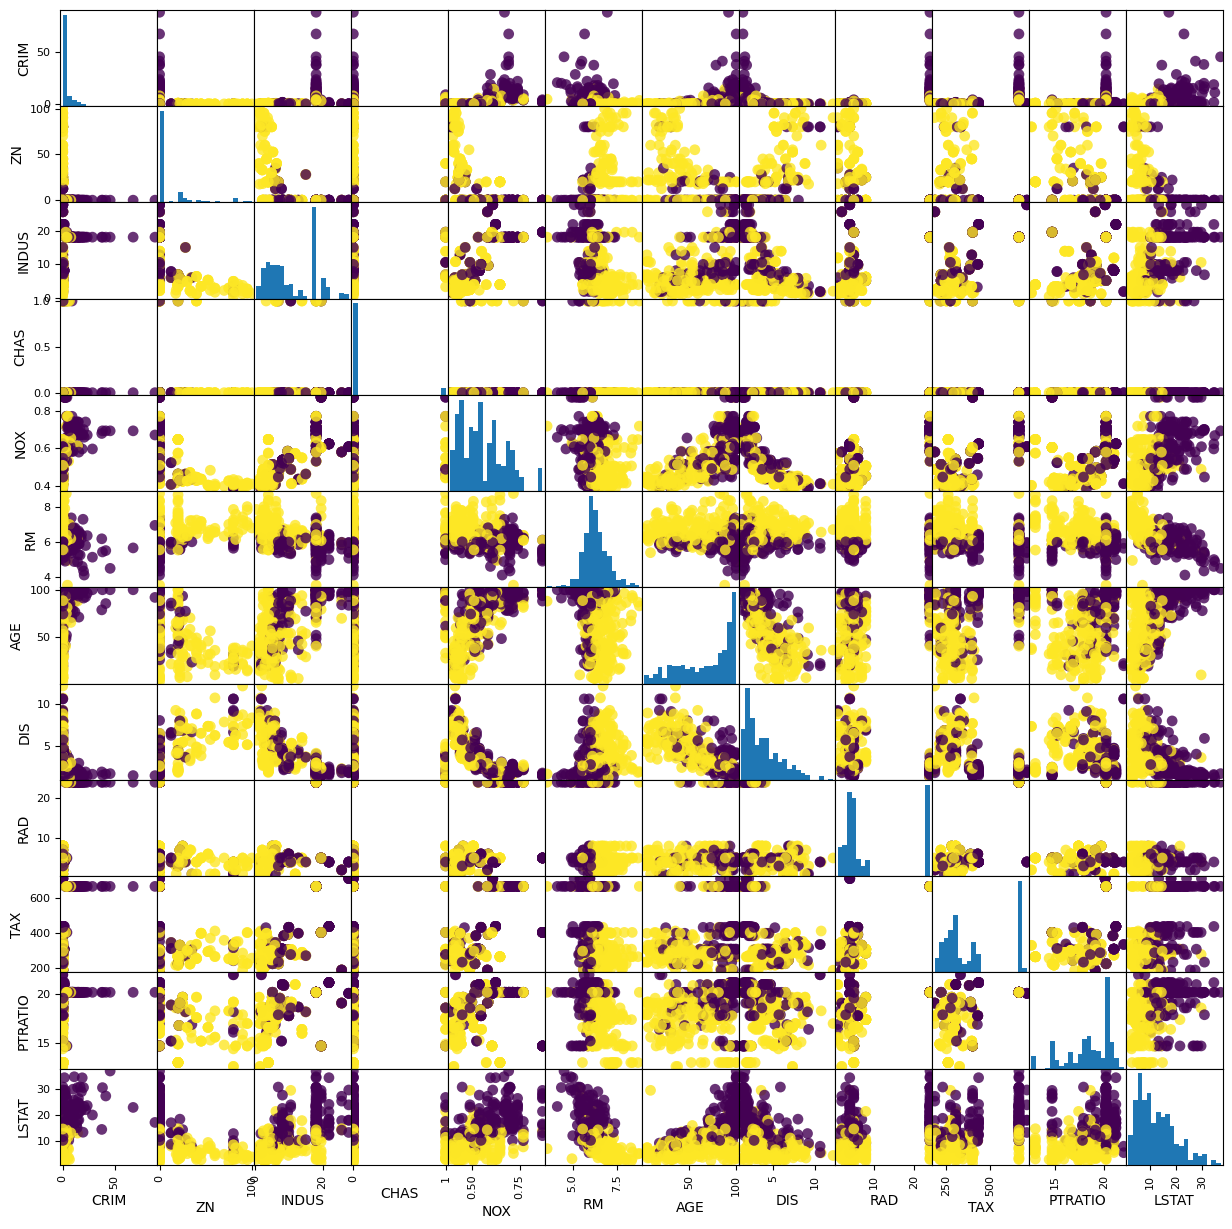

In [6]:
# Create dataframe
data_df = pd.DataFrame(X_train, columns=data['data'].columns.to_list())
# Create scatter plot and color by class label.
%matplotlib inline
import matplotlib.pyplot as plt
_=pd.plotting.scatter_matrix(data_df, c=c_train, figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()

# Exercise set 1

### Model learning
* Learn a decision tree using the training data and evaluate its performance on both the training data and the test data. Generate random training/test partitions or varying sizes and analyze how the accuracy results vary (consult the documentation for `train_test_split(.)`).

In [7]:
## Exercise: Learn a decision tree using the training data and evaluate its performance on both the training data and the test data

## Building and fitting a tree with the training data. Random_state set for repeatability
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0) # With standard setting
tree.fit(X_train, c_train)

DecisionTreeClassifier(random_state=0)

In [8]:
## Calculating the accuracy on the training set
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, c_train)))

## Calculating the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, c_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.780


First we learn a decision tree and fit the data also measuring the accuracy on the training and test data. This creates a baseline model, and once we start doing randomized data set splits, we can compare the performance to the baseline model. 

This doesn't mean that the baseline model is more correct, just that it is a starting point for comparing performance based on other versions of the data sets.

The accuracy on the training set was 100% and on the test set 78%

The 100% fit on the training data suggest overfitting and with a performance of accuracy of 78% on test, this combined does give an impression that overfitting on training data occurs while generalization is not too strong.

In [52]:
## Exercise: Generate random training/test partitions or varying sizes and analyze how the accuracy results vary (consult the documentation for `train_test_split(.)`)

import random
from sklearn.tree import DecisionTreeClassifier

## The purpose of this code is to split the main data set into a randomized test and train set. Each time the function is run, at new number 
## is generated and set as the random_state in the train_test_split function.
## Rerun this function and each time a new split (within the bounds of 0 to 1000, so press the rerun button long enough and you will eventually ->
## see the same number used to set the random_state) will be produced

## Using random produce a number and showing it before using it in random_state ensures repeatability while also having "random" data set

## Producing a random number and prints it
random_number = random.randint(0, 1000)
print("random number generated and used to split the data set: ", random_number)

## Splitting the data set using the random number
X_train_rand, X_test_rand, c_train_rand, c_test_rand = train_test_split(data['data'], c, random_state=random_number)
## building a tree
tree_rand = DecisionTreeClassifier(random_state=0) # With standard setting
tree_rand.fit(X_train_rand, c_train_rand)

X_test_np_rand = X_test_rand.values
#print("Predicted class probabilities tree: {}".format(tree.predict_proba([X_test_np_rand[0,:]])))

## Calculating the accuracy on the training set
print("Accuracy on training set: {:.3f}".format(tree_rand.score(X_train_rand, c_train_rand)))

## Calculating the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(tree_rand.score(X_test_rand, c_test_rand)))


random number generated and used to split the data set:  423
Accuracy on training set: 1.000
Accuracy on test set: 0.827


The code above provides an example of how it is possible to run and then rerun the training of the tree and output the accuracy on the training and test data.

In [ ]:
## Exercise: Generate random training/test partitions or varying sizes and analyze how the accuracy results vary (consult the documentation for `train_test_split(.)`)

import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

## This code automates the rerun and enables configuration of the default test size, which is randomized +/-20%. The randomize_train_size switch can be set to default
# and then the size will remain constant while the random state number changes.
# It also saves the results to a file named randomized_splits_results.csv

# Initialize placeholders for storing results
results = []

# Set the original test size
default_test_size = 0.25

# Randomize the training set size +/- 20%
randomize_train_size = True  # Set to False to keep it fixed

# Run the process 20 times
for i in range(20):
    # Generate a random seed
    random_number = random.randint(0, 1000)
    
    # Adjust the training set size if the switch is enabled
    if randomize_train_size:
        random_test_size = default_test_size + random.uniform(-0.2, 0.2) * default_test_size
    else:
        random_test_size = default_test_size
    
    # Split the dataset
    X_train_rand, X_test_rand, c_train_rand, c_test_rand = train_test_split(
        data['data'], c, test_size=random_test_size, random_state=random_number
    )
    
    # Build and train a Decision Tree classifier
    tree_rand = DecisionTreeClassifier(random_state=0)
    tree_rand.fit(X_train_rand, c_train_rand)
    
    # Calculate accuracy
    train_accuracy = tree_rand.score(X_train_rand, c_train_rand)
    test_accuracy = tree_rand.score(X_test_rand, c_test_rand)
    
    # Store results in a dictionary
    results.append({
        "Run": i + 1,
        "Random State": random_number,
        "Train Size %": f"{(1 - random_test_size) * 100:.1f}",
        "Train Accuracy": f"{train_accuracy:.3f}",
        "Test Accuracy": f"{test_accuracy:.3f}"
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print("Results of 20 Runs with Randomized Splits:")
print(results_df)

# Save results to a CSV file (optional)
results_df.to_csv("randomized_splits_results.csv", index=False)


Results of 20 Runs with Randomized Splits:
    Run  Random State Train Size % Train Accuracy Test Accuracy
0     1           255         79.4          1.000         0.857
1     2           644         71.0          1.000         0.837
2     3           677         71.6          1.000         0.840
3     4            72         77.8          1.000         0.823
4     5           867         78.6          1.000         0.844
5     6           575         73.6          1.000         0.851
6     7           122         77.0          1.000         0.761
7     8           437         70.1          1.000         0.829
8     9           941         72.9          1.000         0.855
9    10           992         78.0          1.000         0.777
10   11             4         76.6          1.000         0.857
11   12            68         74.6          1.000         0.822
12   13           857         70.6          1.000         0.832
13   14           376         78.4          1.000         0.8

From the 20 runs with changing training and test data set size, it is possible to see that the accuracy on the training data remains at 100% on all runs. The accuracy on the test data changes from 76% to 86%, so a fluctuation of 10%.

The results suggest that accuracy is impacted by the size of the training and test split. A fluctuation of 10% is something to be cognizant about when splitting data sets. It also reminds you that when reviewing prediction based on a data set multiple factors impact the prediction power, one of them being test and training data set size.

### Model analysis

* Display the decision tree learned using the training data.
* What are the most important features as determined by the learned tree and does, e.g., the choice of top node seem reasonable to you based on your knowledge of the data domain?
* How does the features deemed *most important* by the decision tree learner match the generated tree and your understanding of the domain?

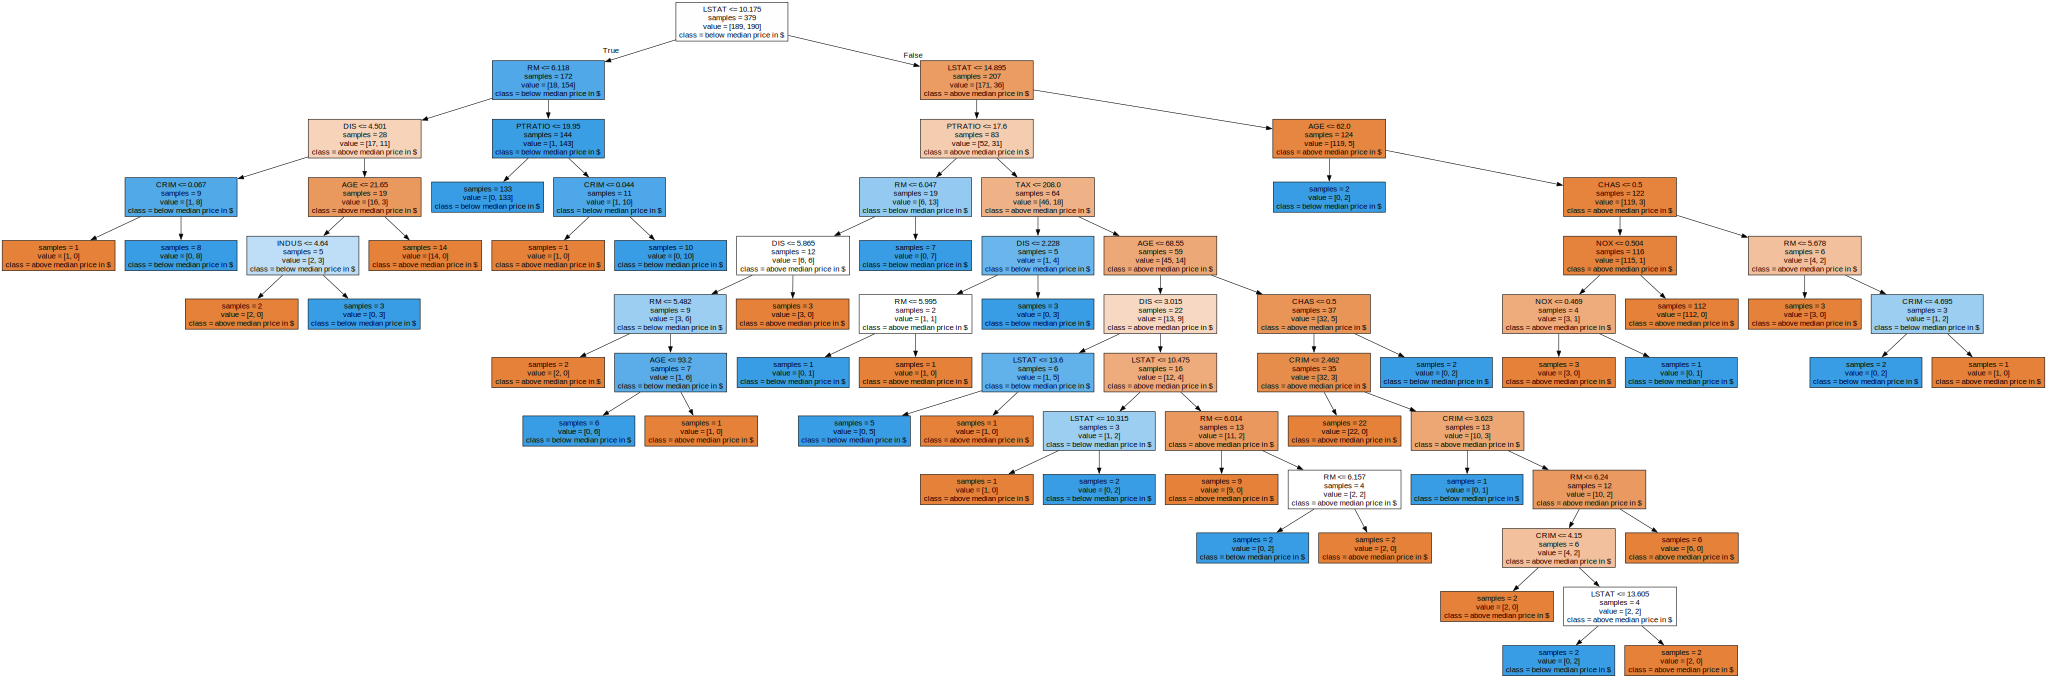

In [12]:
## Exercise: Display the decision tree learned using the training data.

from sklearn.tree import export_graphviz
import graphviz

#print("Feature importances:\n{}".format(tree.feature_importances_))

n_features = data['data'].shape[1]

feature_names = data['data'].columns.tolist()

# plt.yticks(np.arange(n_features), data.feature_names)

export_graphviz(tree, out_file="tree.dot", class_names=["above median price in $", "below median price in $"],
                feature_names=feature_names, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

Above we see the decision tree. The tree is fairly large and does not present a simple model, as we often like to have.

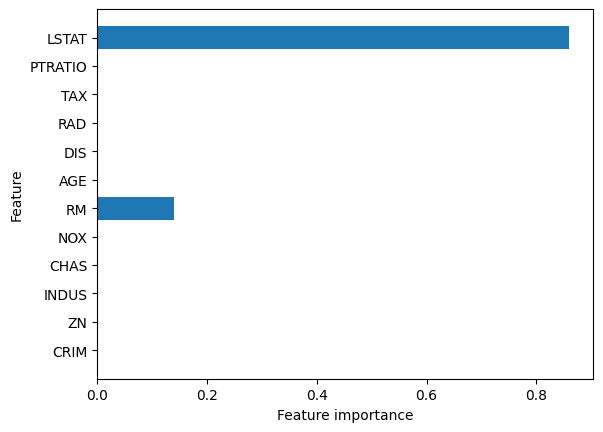

In [53]:
## Exercise: What are the most important features as determined by the learned tree and does, e.g., the choice of top node seem reasonable to you 
# based on your knowledge of the data domain?
def plot_feature_importances_bhousing(model):
    n_features = data['data'].shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

plot_feature_importances_bhousing(tree)

Exercise: How does the features deemed *most important* by the decision tree learner match the generated tree and your understanding of the domain?

The most important feature is **LSTAT** (% of lower status of the population) with a feature importance score of 0.6. The next most important is **RM** (average number of room per dwelling), which scores at below 0.2. The third host important is **DIS** (weighted distances to five Boston employment centres).

That **LSTAT** is most important does not seem unintuitive in that property value and LSTAT probably influences one another. High value property may not often be found in areas with a high density of a population scoring high on LSTAT as persons scoring high on LSTAT would concentrate in areas with people of similar income level. LSTAT may in some cases also be an indirect indicator for other factors such as crime rate, rooms per dwelling, and pupil-teacher ratio by town. 

LSTAT is the top node, which is in line with it scoring very high on feature importance. If the price is below the median, then the two next most imporatant features are relevant. This seems understandable based on their feature importance score. 
If however the property scores above the median price, other factors become more important e.g. **PTRATIO** (pupil-teacher ratio by town) and **AGE** (proportion of owner-occupied units built prior to 1940).
This suggest that the most important features differ depending on the **LSTAT**. For higher value property other factors are more important than for lower value property. 
In high value property areas how old the property is and the pupil-teacher ratio by town more signifcantly impcats the median value of the property. This again does not seem unintuitive as persons which stand strong on the socio economic index would value the age and pupil-teacher ratio as important factors in determining what price is approriate for a property.
Persons looking for property in areas with a high density of persons scoring low on the socio economic index, the distance to a employment center, which is probably more often relevant for this group, helps define the value as does the number of rooms for the family/group that want to find a suitable property, as this may more often be a concern for this group.


### Model complexity
* Try controlling the complexity of the learned decision tree by adjusting the parameters max\_depth, min\_samples\_split, min\_samples\_leaf
* Investigate the effect when changing these parameters:
    - Visualize (some of) the trees
    - Evaluate the performance of the models on both the training data and the test data
* By designating a part of the data as *validation data*, try to automatically find good values for the parameters controlling the size of the tree. How does the obtained parameters match your manual investigation?
* Instead of using a validation set, try to find good parameter values using cross-validation. How does the results compare to those that you found above?

In [14]:
## Exercise: Try controlling the complexity of the learned decision tree by adjusting the parameters max_depth, min_samples_split, min_samples_leaf

from sklearn.tree import DecisionTreeClassifier

## Splitting the data set using the random number
X_train_control, X_test_control, c_train_control, c_test_control = train_test_split(data['data'], c, random_state=42)

## building a tree with max depth of 4 and min sample split at 100
tree_control = DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_split=100) 
tree_control.fit(X_train_control, c_train_control)

X_test_np_control = X_test_control.values

## Calculating the accuracy on the training set
print("Accuracy on training set: {:.3f}".format(tree_control.score(X_train_control, c_train_control)))

## Calculating the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(tree_control.score(X_test_control, c_test_control)))

Accuracy on training set: 0.865
Accuracy on test set: 0.890


When controlling the max depth and min sample split different results are achieved. For this run the accuracy on te training set is 86.5% and on test it is 89%.

There seems less overfitting for this tree and the accuracy is closer for the training and test set. This provides better generalizable results than the previous models, where accuracy on the training data set was 100% and lower than the 89% on the test set.

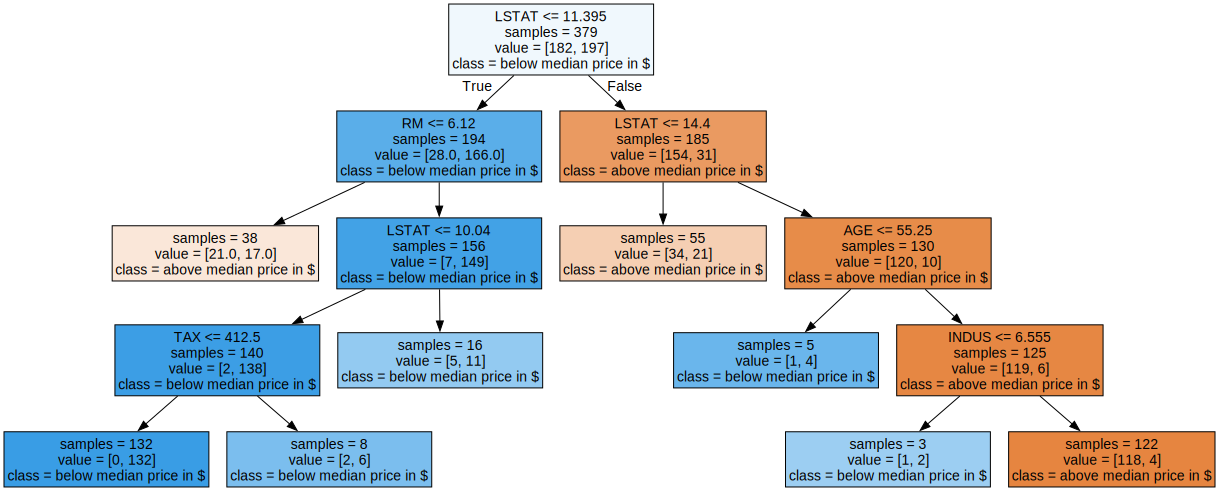

In [ ]:
## Exercise: Visualize (some of) the trees

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree_control, out_file="tree_control.dot", class_names=["above median price in $", "below median price in $"],
                feature_names=feature_names, impurity=False, filled=True)

with open("tree_control.dot") as f:
   dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Placeholder for results
results = []

# Split the dataset using the provided statement
X_train, X_test, c_train, c_test = train_test_split(data['data'], c, random_state=42)

# List of parameter configurations to try
configurations = [
    {"max_depth": None, "min_samples_split": 2},
    {"max_depth": 10, "min_samples_split": 51},
    {"max_depth": 5, "min_samples_split": 51},
    {"max_depth": 2, "min_samples_split": 51},
    {"max_depth": 2, "min_samples_split": 10},
    {"max_depth": 10, "min_samples_split": 10},
    {"max_depth": 4, "min_samples_split": 10},
    {"max_depth": 4, "min_samples_split": 100},
    {"max_depth": 2, "min_samples_split": 100}
]

# Iterate through configurations and train/evaluate each tree
for i, config in enumerate(configurations, start=1):
    # Build and train the decision tree with current configuration
    tree = DecisionTreeClassifier(random_state=0, 
                                   max_depth=config["max_depth"], 
                                   min_samples_split=config["min_samples_split"])
    tree.fit(X_train, c_train)
    
    # Calculate accuracies
    train_accuracy = tree.score(X_train, c_train)
    test_accuracy = tree.score(X_test, c_test)
    
    # Store the result
    results.append({
        "Try": i,
        "max_depth": config["max_depth"],
        "min_samples_split": config["min_samples_split"],
        "Accuracy on training set": f"{train_accuracy * 100:.1f}%",
        "Accuracy on test set": f"{test_accuracy * 100:.1f}%"
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by test accuracy
results_df_sorted = results_df.sort_values(by="Accuracy on test set", ascending=False)

# Display all results
print("All Decision Tree Configurations and Their Results:")
display(results_df)

# Display top 3 configurations
print("\nTop 3 Configurations Based on Test Accuracy:")
display(results_df_sorted.head(3))


All Decision Tree Configurations and Their Results:


,Try,max_depth,min_samples_split,Accuracy on training set,Accuracy on test set
0,1,NaN,2,100.0%,83.5%
1,2,10.0,51,86.5%,89.0%
2,3,5.0,51,86.5%,89.0%
3,4,2.0,51,85.5%,89.0%
4,5,2.0,10,85.5%,89.0%
5,6,10.0,10,93.4%,87.4%
6,7,4.0,10,90.5%,85.0%
7,8,4.0,100,86.5%,89.0%
8,9,2.0,100,85.5%,89.0%



Top 3 Configurations Based on Test Accuracy:


,Try,max_depth,min_samples_split,Accuracy on training set,Accuracy on test set
1,2,10.0,51,86.5%,89.0%
2,3,5.0,51,86.5%,89.0%
3,4,2.0,51,85.5%,89.0%



In this part I built a series of trees with varying maximum depth and minimum sample split. Maximum depth controls the depth of leaves allowed, meaning how many layers are the maximum. The minimum sample split means that in any split at least the defined number of samples has to be present to perform a split.

The max depth and min sample split were change from one try to the next, to see how the performance of the accuracy was impacted.

Firstly we baseline with not setting any values for max depth and min sample split. It provides 100% accurany on the training set, which is not entirely unexpected. It may often result in overfitting, meaning the model becomes very complex and takes "all" even edge cases into account. It's performance on the test set it 83,5%

It would be helpful to have a model that is not too complex and that has strong performance on the test set - simplicity is key.

Trying out different scenarios several has a better fit on the training data that the baseline model, and several hit the 89% mark. 

No single model stands out, but try 8 has a depth of 4 and a min split of 100. This makes for a fairly simple model, meaning a rather high number of samples are required for a split and the depth (at 4) is limited. Model 9 is even more limited in depth at 2 and only loses 1% in the training set accuracy but none in the test set, making it a compelling model.

Max depth: 2
min sample split: 100
Accurancy on training set: 85,5%
Accurancy on test set: 89%

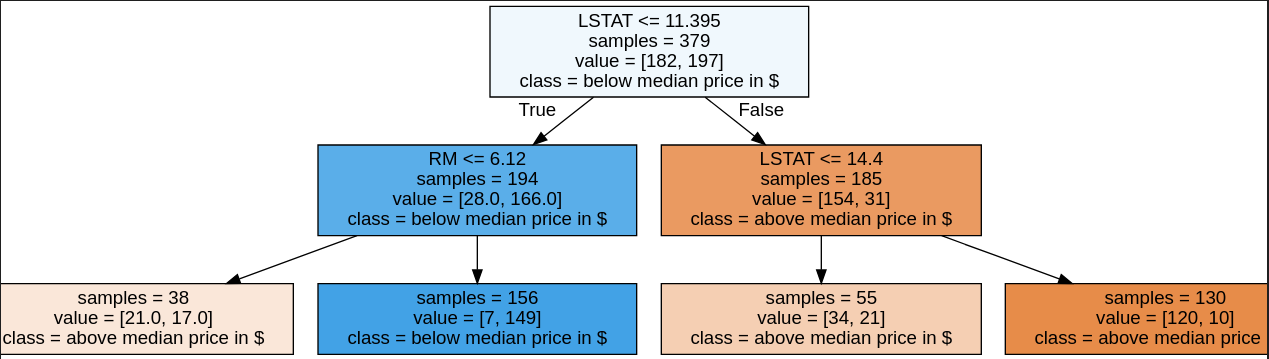

In the next section we'll look at how to find good parameters for the tree. The data will be split into a test, a training and a validation set. 
Firsly a basic model will be used to baseline. Next a model to find parameters automatically but without cross validation and finally a model that uses cross validation will be used.

Finally the output of the three model will be compared and discussed.

In [30]:
## Setting up that data

c = np.array([1 if y > np.median(data['target']) else 0 for y in data['target']])
## Splitting the data set in to a train and test data set
X1_trainVal, X1_test, y1_trainVal, y1_test = train_test_split(data['data'], c, random_state=1)
## Further splitting the training data set into a validation and a training set
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_trainVal, y1_trainVal, random_state=1)

In [35]:
## building a tree for a baseline model
max_depth_baseline = 3
min_sample_split_baseline = 100
tree_baseline = DecisionTreeClassifier(random_state=1, max_depth=max_depth_baseline, min_samples_split=min_sample_split_baseline) 
tree_baseline.fit(X1_train, y1_train)

X1_test_np = X1_test.values

train_accuracy = tree_baseline.score(X1_train, y1_train)
test_accuracy = tree_baseline.score(X1_test, y1_test)

# Saving the results
baseline_results = {
    'Model': 'Baseline',
    'Max Depth': max_depth_baseline,
    'Min Samples Split': min_sample_split_baseline,
    'Training Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
}

## Append results to the results list
results_list = [baseline_results]

## Calculating the accuracy on the training set
print("Accuracy on training set: {:.3f}".format(train_accuracy))

## Calculating the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(test_accuracy))

Accuracy on training set: 0.884
Accuracy on test set: 0.843


In [34]:
## By designating a part of the data as *validation data*, try to automatically find good values for the parameters 
# controlling the size of the tree. How does the obtained parameters match your manual investigation?

## Here we set out to find good values for the parameters iterating through different max depth and min sample split, evaluating the accuracy score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train the model with different parameter values
best_score = 0
best_params = {}

for max_depth in [3, 4, 5, 10, None]:
    for min_samples_split in [2, 5, 10, 20, 51, 100]:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=11)
        clf.fit(X1_train, y1_train)
        y1_val_pred = clf.predict(X1_val)
        score = accuracy_score(y1_val, y1_val_pred)
        #print("The score is: ", score)
        
        if score > best_score:
            best_score = score            
            best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

print(f"Best Parameters: {best_params}, Validation Accuracy: {best_score}")

## Extracting the bets parameters of max depth and min sample split
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']

## ------ After having found the best parameters, building a tree with those parameters and seeing performance on training and test data set ----------##

## building a tree
tree_val_control = DecisionTreeClassifier(random_state=1, max_depth=best_max_depth, min_samples_split=best_min_samples_split) 
tree_val_control.fit(X1_train, y1_train)

# Accuracy on training and test set
train_accuracy = tree_val_control.score(X1_train, y1_train)
test_accuracy = tree_val_control.score(X1_test, y1_test)

# Saving the results
manual_tuning_results = {
    'Model': 'Manual Parameter Tuning',
    'Max Depth': best_params['max_depth'],
    'Min Samples Split': best_params['min_samples_split'],
    'Training Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
}

# Append results to the results list
results_list.append(manual_tuning_results)

X1_test_np = X1_test.values

## Calculating the accuracy on the training set
print("Accuracy on training set: {:.3f}".format(train_accuracy))

## Calculating the accuracy on the test set
print("Accuracy on test set: {:.3f}".format(test_accuracy))


Best Parameters: {'max_depth': 3, 'min_samples_split': 2}, Validation Accuracy: 0.8
Accuracy on training set: 0.905
Accuracy on test set: 0.850


Having iterated through several max depth and min sample splits, we arrive at a configuration that achieves the highest accuracy score. The configuration is max depth of 3 and a min sample split of 2. The accuracy on the validation set is 80%, 90.5% on the training set and 85% on the test set.

While these parameters provide a high accuracy they also provide a simple model, which is also desirable.

In [55]:
## Exercise: Instead of using a validation set, try to find good parameter values using cross-validation. How does the results compare to those that you found above?

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Preparing the tree
tree_val = DecisionTreeClassifier(random_state=1) ## Preparing the tree without parameters 

## Setting values for the parameter ranges
param_grid = {
    'max_depth': [3, 4, 5, 10, 20, None],  # Example depths to try
    'min_samples_split': [2, 5, 10, 20, 51, 100]  # Minimum samples for a split
}

## Preparing a function for grid search with cross-validation
grid_search = GridSearchCV(
    estimator=tree_val, ## Using the defined tree
    param_grid=param_grid, ## Using the define parameter
    cv=5,  ## setting a 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
)

## Fit the grid search on the training set
grid_search.fit(X1_train, y1_train)

## Finding the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters from GridSearchCV: {best_params}, Cross-Validation Accuracy: {best_score}")

best_model = grid_search.best_estimator_

# Accuracy on validation and test sets
validation_accuracy = accuracy_score(y1_val, best_model.predict(X1_val))
test_accuracy = accuracy_score(y1_test, best_model.predict(X1_test))

# Saving the results
grid_search_results = {
    'Model': 'GridSearchCV (Cross-Validation)',
    'Max Depth': best_params['max_depth'],
    'Min Samples Split': best_params['min_samples_split'],
    'Training Accuracy': best_score,
    'Validation Accuracy': validation_accuracy,
    'Test Accuracy': test_accuracy
}

print(grid_search_results)

# Append results to the results list
results_list.append(grid_search_results)

Best Parameters from GridSearchCV: {'max_depth': 3, 'min_samples_split': 100}, Cross-Validation Accuracy: 0.8449248120300752
{'Model': 'GridSearchCV (Cross-Validation)', 'Max Depth': 3, 'Min Samples Split': 100, 'Training Accuracy': np.float64(0.8449248120300752), 'Validation Accuracy': 0.8, 'Test Accuracy': 0.84251968503937}


When using cross validation we arrive at the same max depth of 3, while the min sample split is 100. The cross validation accuracy is 84.5% on the training set, and a test accuracy of 84.3%

These results are very close to the results without the cross validation.

In [39]:
#%pip install jinja2 ## Uncomment in case this is not installed

import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Format the accuracy columns as percentages with two decimal places
accuracy_columns = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
for col in accuracy_columns:
    if col in results_df.columns:  # Only format if the column exists
        results_df[col] = (results_df[col] * 100).map("{:.2f}%".format)

# Style the DataFrame for display
styled_table = results_df.style.set_properties(
    subset=['Model'], **{'text-align': 'left'}  # Left-align text in the 'Model' column
).set_properties(
    subset=accuracy_columns + ['Max Depth', 'Min Samples Split'], 
    **{'text-align': 'center'}  # Center-align numeric values
).set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]}  # Center-align headers
])

# Display the styled table
styled_table


,Model,Max Depth,Min Samples Split,Training Accuracy,Test Accuracy,Validation Accuracy
0,Baseline,3,100,88.38%,84.25%,nan%
1,GridSearchCV (Cross-Validation),3,100,84.49%,84.25%,80.00%


# Exercise set 2

In this exercise we shall expore and compare the k-nearest neighbor classifier and the naive Bayes model.

### K-nearest neighbor
* Classify the instances in the test set using default settings for the k-NN classifier.
* Try experimenting with different values for 'k'. How do the values affect the classification results? Feel free to try to automate this process using the methods explored in the previous exercise sheet. 
* Try to get some more insight into the data by generating descriptive statistics and by plotting the data. 
* Based on your understanding of the data and the properties of the k-NN classifier, does it seem reasonable to try to manipulate the data (e.g. through normalization) or work with different distance metrics in order to improve the performance of the classifier? How does such changes affect classification accuracy?

### Naive Bayes

* Classify the instances in the test set using the naive Bayes model.
* The naive Bayes classifier makes the strong assumption that the attributes are conditionally independent given the class variable. Can you identify any pairs of attributes that do not adhere to this assumption, and how does it affect the performance of the classifier if one of the attributes are removed?

### Model comparison

* Using the results obtained above, classify the instances in the test set using the k-NN classifier, the naive Bayes classifier, and decision trees.
* Based on your intuitive understanding of the classifiers, can you explain their relative performance? 

In [44]:
## Exercise Text: Classify the instances in the test set using default settings for the k-NN classifier.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a binary target variable based on the median of 'MEDV'
df['MEDV_Class'] = np.array([1 if y > np.median(df['MEDV']) else 0 for y in df['MEDV']])

# Prepare the feature set (X) and target set (y)
X = df.drop(columns=['MEDV', 'MEDV_Class'])  # Features (all columns except target)
y = df['MEDV_Class']  # Target variable (binary classification)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)

# Initialize the k-NN classifier (default k=5)
knn = KNeighborsClassifier()

# Train the model on the training data
knn.fit(X_train, y_train)

# Predict the target on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the result
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Accuracy on the test set: 83.46%


With out specifying the number of neighbors the model arrives at 83.46% accuracy on the test set.

This serves as a good baseline model.

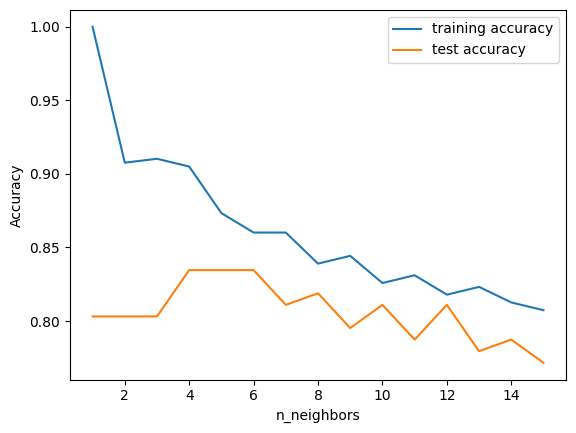


Best k value: 4 with Test Accuracy: 0.8346


In [45]:
## Exercise: Try experimenting with different values for 'k'. How do the values affect the classification results? Feel free to try to automate this process using the methods explored in the previous exercise sheet. 

from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
## Setting n_neighbors from 1 to 15
neighbors_settings = range(1, 16)

## The model runs through the set different values of neighbor values
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
## Showing a plot with accuracy of the different neighbor values
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

best_k = neighbors_settings[np.argmax(test_accuracy)]
print(f"\nBest k value: {best_k} with Test Accuracy: {max(test_accuracy):.4f}")

The plot shows the development of accuracy on the training and test data sets with different number of neighbors.

What we aim for is a model that does not overfit on the training set and has a good ability to generalize on the test set.

The plot shows that with only 1 or 2 nearest neighbors it has a very high accuracy on the training data, suggesting overfitting. As more neighbors are used the accuracy on the training data falls and the accuracy on the test data increases, At about 4-6 nearest neighbors the accuracy on the test data hit a high peak of almost 85%, while the accuracy on the training data falls. This suggest a model with around 4-6 neighbors is a model that balances accuracy on training and test data, having a good performance and ability to generalize. After 6 the accuracy on the test data falls as does the accuracy on the training data.

Another aim is to have a simple model, which will also require less compute power one released onto other data sets. A value of 4 seems to strike a good balance achieving 1) a simple model 2) high degree of accuracy on the test data and 3) a high but no too high accuracy (overfitting) on the training data. The accuracy on the test data for 4 is 83.43%

While this exercise provides more insight into the balance between accuracy on test and training set, the resulting accuracy is close to the 83.46% obtained without setting any parameters. The suggests that the model without any parameters arrive at a similar configuration.

Training Accuracy for k=4: 0.9050
Test Accuracy for k=4: 0.8346

Confusion Matrix:
[[62 11]
 [10 44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        73
           1       0.80      0.81      0.81        54

    accuracy                           0.83       127
   macro avg       0.83      0.83      0.83       127
weighted avg       0.84      0.83      0.83       127



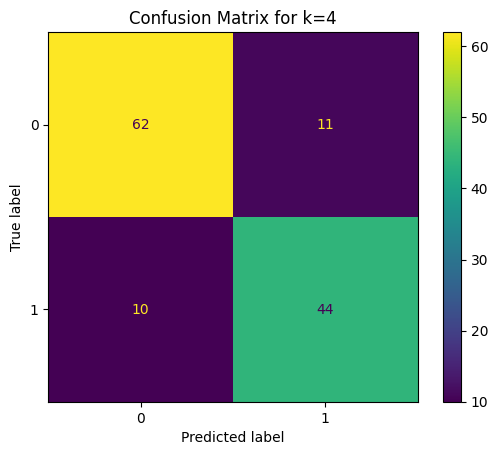

In [46]:
## Exercise: Try to get some more insight into the data by generating descriptive statistics and by plotting the data. 

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Here we use k = 4 and also print a confusion matrix

# Step 1: Build the k-NN model with k=4
k = 4
clf = KNeighborsClassifier(n_neighbors=k)

# Step 2: Fit the model to the training data
clf.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 4: Calculate and print accuracy
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print(f"Training Accuracy for k={k}: {train_accuracy:.4f}")
print(f"Test Accuracy for k={k}: {test_accuracy:.4f}")

# Step 5: Print the Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6: Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="viridis")
plt.title(f"Confusion Matrix for k={k}")
plt.show()


Using k=4 a confusion matrix is shown. 

On the y-axis are the true values (the actual values) and x-axis are the predicted labels. There are 127 samples in the test.

The model predicted 62 samples as 0 that was in fact 0 and 10 as 0 that was not 0. It predicted 44 as 1 that was 1, and 11 as 1 that was 0. To sum up the model correctly classified 44+62 = 106 and misclassified 10+11 = 21. The accuracy is 83.46% (106/127).

In [48]:
# Print sizes of training, test, and validation datasets
print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Validation set size: {X1_val.shape[0]} samples, {X1_val.shape[1]} features")


Training set size: 379 samples, 12 features
Test set size: 127 samples, 12 features
Validation set size: 95 samples, 12 features


**Exercise**: Based on your understanding of the data and the properties of the k-NN classifier, does it seem reasonable to try to manipulate the data (e.g. through normalization) or work with different distance metrics in order to improve the performance of the classifier? How does such changes affect classification accuracy?

To answer that questions, let us turn to the description of the data set

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

Variables in order:
CRIM     per capita crime rate by town  
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.  
INDUS    proportion of non-retail business acres per town  
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)  
 NOX      nitric oxides concentration (parts per 10 million)  
 RM       average number of rooms per dwelling  
 AGE      proportion of owner-occupied units built prior to 1940  
 DIS      weighted distances to five Boston employment centres  
 RAD      index of accessibility to radial highways  
 TAX      full-value property-tax rate per $10,000  
 PTRATIO  pupil-teacher ratio by town  
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town  
 LSTAT    % lower status of the population  
 MEDV     Median value of owner-occupied homes in $1000's  

The features in the data set are on different scales and represent very different types of data, and hence there could be an argument for normalization. 

Since no specific metric has been set thus far when using the kneighborclassifier the default (euclidean) has been used. Let's do some comparison.

In the next code section the same data is used but normalized and we iterate through three metrics, euclidean, manhattan and chebyshev. 

The euclidean is the default for kneighborclassifier and uses a straight line between two points
Manhattan uses the absolute differences between corresponding features and is less sensitive to outliers compared to euclidean
Chebyshev focuses on the largest single difference between any pair of features.

In [49]:
## Exercise: Based on your understanding of the data and the properties of the k-NN classifier, does it seem reasonable to try to manipulate the data (e.g. through normalization) or 
# work with different distance metrics in order to improve the performance of the classifier? How does such changes affect classification accuracy?

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Step 1: Normalize the data using Min-Max Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Compare different distance metrics
metrics = ['euclidean', 'manhattan', 'chebyshev']
for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=4, metric=metric)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    # Print results
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {metric} distance: {acc:.4f}")


Accuracy with euclidean distance: 0.8189
Accuracy with manhattan distance: 0.8031
Accuracy with chebyshev distance: 0.8031


The accuracy are 81.89% for euclidean with normalized data on the test data set. This can be compared to accuracy before normalization of 83.46% for unnormalized data.

Manhattan and Chebyshev both produce an accuracy of 80.31%

The change in accuracy from unnormalized to normalized (Euclidean) suggests that some features have more impact before normalization. Thinking back on the feature importance overview, this is not wholly unexpected.

We want a model that can explain a certain phenomenon to the greatest degree. Here we see that normalizing the data decreases the accuracy of the model, as features that greatly influence the model are normalized and hence their weight change. In certain cases there can be an argument for _not_ normalizing the data, if it negatively changes it is power of prediction.

If we are working with very large data sets, performing additional computations such as normalizing which either does not greatly change or negatively impacts the prediction power, there would be little reason to spend additional time and energy (electric energy) on the operation. In the future as working on large data set becomes more common and with emergence of discussions about green computing, such considerations are worth taking into account.